SVM

In [1]:
#　実際に推定を行うため、シンプルデータセット1の2値分類を取り込む

import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)])

In [2]:
#　データを分割する

y=y.reshape(len(y),1)
from sklearn.model_selection import train_test_split
data_all_sp=train_test_split(X,y)

train_X,test_X,train_y,test_y=data_all_sp

In [3]:
#　一応標準化した場合のものも作成
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)
train_X1sd=scaler.transform(train_X)

In [4]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(375, 2)
(125, 2)
(375, 1)
(125, 1)


完成雛形

In [5]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    """
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        
        # 学習過程を記録する配列を用意
        self.verbose_list=[]
        self.verbose_list_val=[]
        
        
    def _kernel(self,X,i,j):
        """
        x:(n_samples, n_features)
        """
        if self.kernel=="linear":
            a=1
            b=0
            c=1
        else:            
            a=1
            b=1
            c=2
            
        e=((a*(X[i].reshape(1,-1)@X[j].reshape(-1,1)))+b)**c
        f=e[0][0]
        return f
    
    def _lamda_Calculate(self,X,y):
        for i in range(len(X)):
            total=0
            for j in range(len(X)):
                total+=self.lamda[j]*y[i]*y[j]*self._kernel(X,i,j)           
            lamda_point=self.lamda[i]+self.lr*(1-total)                                       
            
            if lamda_point>=0:
                self.lamda[i]=lamda_point
            else:
                self.lamda[i]=0
        self.verbose_list.append(self.lamda)                       
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        import numpy as np
        #　初期値
        self.lamda=np.ones(len(X))
        
        #　lamdaの計算
        #lamda_list = np.zeros(len(X))
        
        # 計算を展開
        for _ in range(self.iter):
            self._lamda_Calculate(X,y)
        
        # サポートベクター取得とインスタンス変数に保存
        # 閾値以上のラムダの値を持つもの
        self.sv_lamda=self.lamda[self.lamda > self.threshold]
        # 閾値以上のラムダの値を持つもののインデックス
        self.sv_index=np.where(self.lamda > self.threshold) 
        # 閾値以上のラムダの値を持つものの特徴量
        self.sv_x=X[self.lamda > self.threshold]
        # 閾値以上のラムダの値を持つもののラベル
        self.sv_label=y[self.lamda > self.threshold]                
                
        if self.verbose:
            print(self.verbose_list)
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """        
        y_pred=[]
        for i in range(len(X)):
            total=0
            for n in range(len(self.sv_lamda)):
                total+=self.sv_lamda[n]*self.sv_label[n]*(X[i].reshape(1,-1)@self.sv_x[n].reshape(-1,1))
            if total>=0:
                y_pred.append(1)
            else:
                y_pred.append(-1)          
        return y_pred

In [7]:
# 実装実行例

SSVM1=ScratchSVMClassifier(num_iter=50,lr=0.01,kernel='linear',threshold=1e-5,verbose=False)
SSVM1.fit(train_X,train_y,X_val=None,y_val=None)

In [8]:
#　インスタンス変数に保存されたサポートベクターを確認
SSVM1.sv_lamda

array([4.56678525e-02, 2.01718451e-02, 1.50427766e-02, 4.74594442e-02,
       5.50797312e-04, 7.80764021e-04, 8.12130322e-03, 8.55393986e-05,
       4.07369066e-03, 4.00152680e-02, 1.28058344e-01, 4.16469760e-01])

In [9]:
SSVM1.sv_index

(array([ 37,  57, 170, 201, 210, 211, 238, 282, 285, 367, 372, 374]),)

In [10]:
SSVM1.sv_x

array([[-0.50179779,  0.74466058],
       [ 1.28107479, -0.21320964],
       [ 1.21732779, -0.30296356],
       [ 0.67098941, -0.58384118],
       [ 0.14096048,  1.74864676],
       [ 0.31369184,  1.90748822],
       [ 2.71714245,  0.98076082],
       [-1.76320579, -0.07237927],
       [ 0.9829958 , -0.6091934 ],
       [ 1.29767058, -0.64553225],
       [ 0.31731679,  2.22551981],
       [ 1.10298263, -0.54852515]])

In [11]:
SSVM1.sv_label

array([[ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1]])

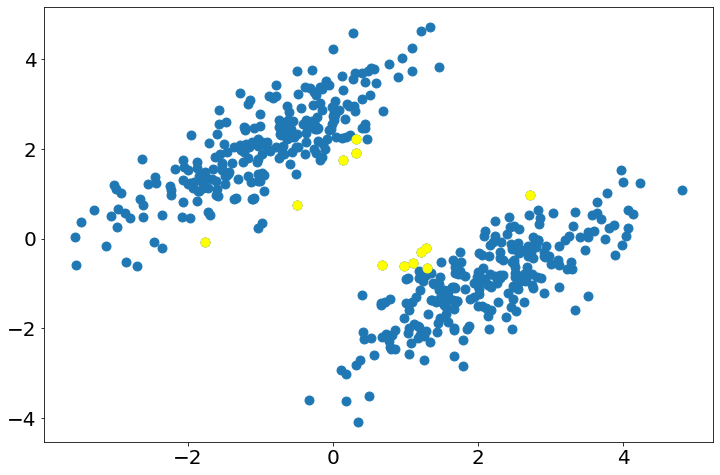

In [14]:
# プロットでサポートベクターを可視化
# グラフ上ではしっかりとサポートベクターが取れている

import matplotlib.pyplot as plt
# Visualizing Simple Data 1
fig = plt.subplots(figsize=(12,8))
plt.rcParams["font.size"] = 20
plt.scatter(X[:,0],X[:,1],s=80)
plt.scatter(SSVM1.sv_x[:,0],SSVM1.sv_x[:,1],s=80,color="yellow")
plt.show()

In [15]:
# predictを行う
# 試しにtest_Xの０から９の１０個の推定を行う

SSVM1.predict(test_X[0:9])

[-1, 1, 1, 1, 1, 1, -1, -1, -1]

In [25]:
y_pred2=SSVM1.predict(test_X[0:9])

In [17]:
test_y[0:9]

array([[-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1]])

１０個では予測値が実際の値とピッタリ一致をしたので問題はなさそう

【問題1】ラグランジュの未定乗数法による最急降下・・・完成雛形の中の_lamda_Calculateで行う

【問題2】サポートベクターの決定・・・完成雛形の中のfitでインスタンス変数に保存、上の実装例でサポートベクターを確認

【問題3】推定・・・完成雛形の中のpredictで実装、加えて実際のものと比べてもピッタリと一致した

【問題4】学習と推定

In [23]:
# scikit-learnとの比較、predictは一致した

train_y1=train_y.reshape(375,)
from sklearn.svm import SVC
SVM1 = SVC()
SVM1.fit(train_X,train_y1)
SVM1.predict(test_X[0:9])

array([-1,  1,  1,  1,  1,  1, -1, -1, -1])

In [26]:
# Accuracy（正解率）
from sklearn.metrics import accuracy_score
accuracy_score(test_y[0:9],y_pred2)

1.0

In [27]:
# Precision（適合率）
from sklearn.metrics import precision_score
precision_score(test_y[0:9],y_pred2)

1.0

In [28]:
# Recall（再現率）
from sklearn.metrics import recall_score
recall_score(test_y[0:9],y_pred2)

1.0

In [29]:
from sklearn.metrics import f1_score
f1_score(test_y[0:9],y_pred2)

1.0

指標の数値も良いものであった

【問題5】決定領域の可視化

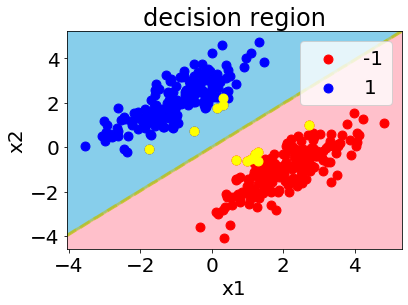

In [86]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
X=train_X
y=train_y
y=y.reshape(len(y),)
step=0.01
title='decision region'
xlabel='x1'
ylabel='x2'
target_names=['-1', '1']
"""
2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
背景の色が学習したモデルによる推定値から描画される。
散布図の点は訓練データまたは検証データである。
Parameters
----------------
X : ndarray, shape(n_samples, 2)
    特徴量
y : ndarray, shape(n_samples,)
    ラベル
model : object
    学習したモデルのインスンタスを入れる
step : float, (default : 0.1)
    推定値を計算する間隔を設定する
title : str
    グラフのタイトルの文章を与える
xlabel, ylabel : str
    軸ラベルの文章を与える
target_names= : list of str
    凡例の一覧を与える
"""
# setting
scatter_color = ['red', 'blue']
contourf_color = ['pink', 'skyblue']
n_class = 2
# pred
mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

model_mesh=SSVM1.predict(mesh)
model_mesh=np.array(model_mesh)

y_pred = model_mesh.reshape(mesh_f0.shape)
# plot
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
for i, target in enumerate(np.unique(y)):
    plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
plt.scatter(SSVM1.sv_x[:,0],SSVM1.sv_x[:,1],s=80,color="yellow")
plt.legend(handles=patches)
plt.legend()
plt.show()

【問題6】（アドバンス課題）多項式カーネル関数の作成・・・完成雛形で一部を作成